# Import Data

In [160]:
import quandl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models
import warnings # This is a library that handles warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [161]:
# Configure API key 
quandl.ApiConfig.api_key = 'iRYyCExAjDDNyB6KZghz'

In [162]:
# Importing the Federal Reserve Economic Data "Total Revenue for Music Publishers, All Establishments, Employer Firms" variable
data = quandl.get('FRED/REVEF51223ALLEST')

In [163]:
# Check
data.head()

,Value
Date,
2002-01-01,3348.0
2003-01-01,3859.0
2004-01-01,3919.0
2005-01-01,4335.0
2006-01-01,4646.0


In [164]:
data.shape

(19, 1)

In [165]:
data.columns

Index(['Value'], dtype='object')

In [166]:
type(data)

pandas.core.frame.DataFrame

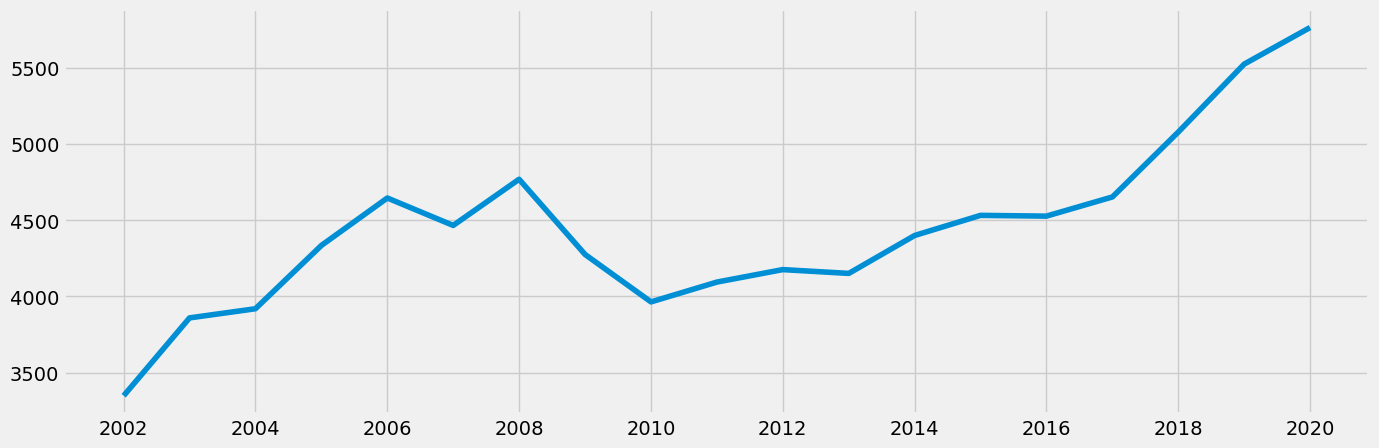

In [167]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

I chose this data set as it has somehow tangential to my data set on Spotify songs. 
The data is provided by the Federal Reserve and shows the revenues of music publishers in the US between 2002 and 2020. This data is reported on annual basis since 2002. Considering this short time frame and thus the small size of the data set, not subsetting is required for the analysis.

# Wrangling and Cleaning Time-Series Data

In [168]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [169]:
data_2.head()

,Date,Value
0,2002-01-01,3348.0
1,2003-01-01,3859.0
2,2004-01-01,3919.0
3,2005-01-01,4335.0
4,2006-01-01,4646.0


In [170]:
data_2["Date"].astype

<bound method NDFrame.astype of 0    2002-01-01
1    2003-01-01
2    2004-01-01
3    2005-01-01
4    2006-01-01
5    2007-01-01
6    2008-01-01
7    2009-01-01
8    2010-01-01
9    2011-01-01
10   2012-01-01
11   2013-01-01
12   2014-01-01
13   2015-01-01
14   2016-01-01
15   2017-01-01
16   2018-01-01
17   2019-01-01
18   2020-01-01
Name: Date, dtype: datetime64[ns]>

In [171]:
# Convert epoch time
# https://stackoverflow.com/questions/51155370/how-can-i-convert-epoch-datetime-in-python

from datetime import datetime
datetime.fromtimestamp(1485714600).strftime("%Y-%m-%d %I:%M:%S")

'2017-01-29 07:30:00'

In [172]:
data_2.head()

,Date,Value
0,2002-01-01,3348.0
1,2003-01-01,3859.0
2,2004-01-01,3919.0
3,2005-01-01,4335.0
4,2006-01-01,4646.0


In [173]:
data_2["Date"].astype

<bound method NDFrame.astype of 0    2002-01-01
1    2003-01-01
2    2004-01-01
3    2005-01-01
4    2006-01-01
5    2007-01-01
6    2008-01-01
7    2009-01-01
8    2010-01-01
9    2011-01-01
10   2012-01-01
11   2013-01-01
12   2014-01-01
13   2015-01-01
14   2016-01-01
15   2017-01-01
16   2018-01-01
17   2019-01-01
18   2020-01-01
Name: Date, dtype: datetime64[ns]>

In [174]:
# Set the "Date" column as the index

from datetime import datetime

data_2['datetime'] = pd.to_datetime(data_2['Date']) # Create a datetime column from "Date"
data_2 = data_2.set_index('datetime') # Set the datetime as the index of the dataframe
data_2.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column
data_2.head()

,Value
datetime,
2002-01-01,3348.0
2003-01-01,3859.0
2004-01-01,3919.0
2005-01-01,4335.0
2006-01-01,4646.0


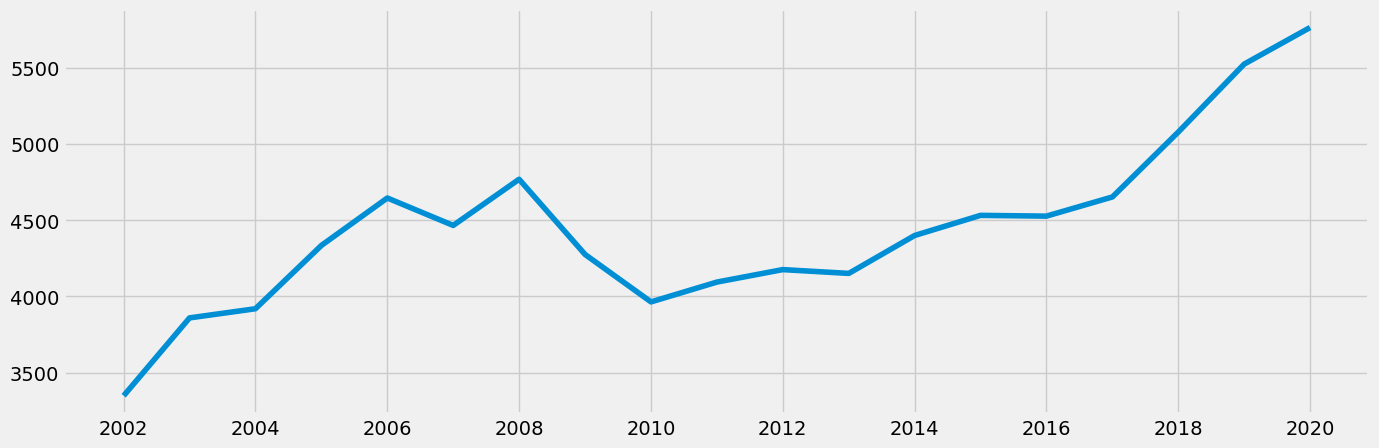

In [175]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_2)

In [176]:
# Check for missing values
data_2.isnull().sum() 

Value    0
dtype: int64

In [177]:
# Check for duplicates
dups = data_2.duplicated()
dups.sum()
# No dups!

0

# Time-Series Analysis: Decomposition

In [178]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_2, model='additive')

In [179]:
from pylab import rcParams # This will define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

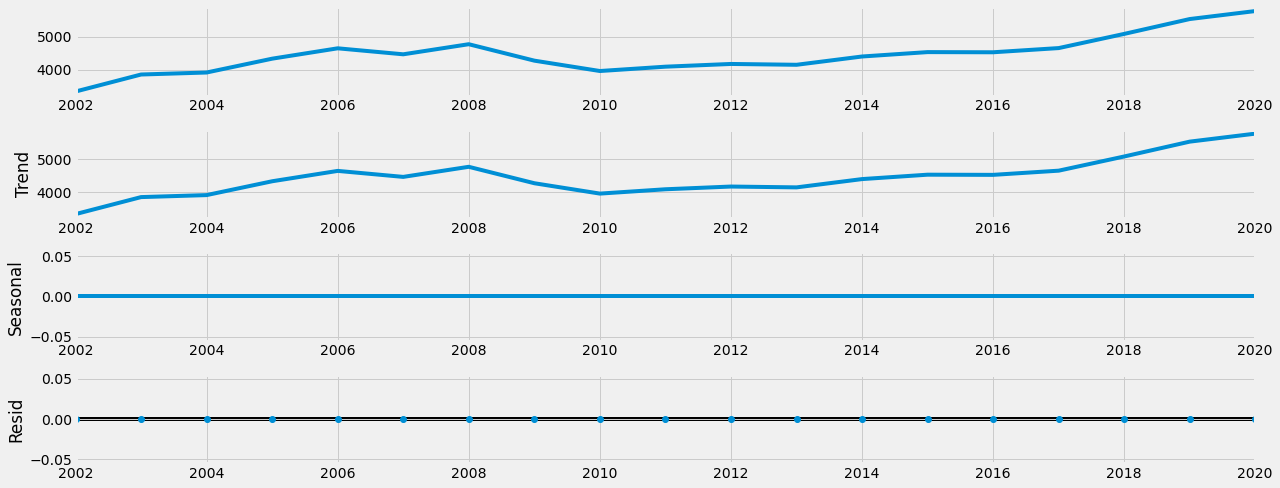

In [180]:
# Plot the separate components
decomposition.plot()
plt.show()

* The trend in the chart is generally upwards, with a stronger decline right after 2008, likely due to the global financial crisis, followed by a rebound up until 2020.

* The seasonality chart is completely flat, implying that there is no seasonality in the data. 

* The residual chart is flat too which means that there is not much unexplained noise in the data.

# Testing for Stationarity

## The Dickey-Fuller Test

In [181]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.009659
p-value                         0.959324
Number of Lags Used             3.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


* The null hypothesis: the presence of a unit root (unit root = any random jump that can’t be explained by variation in the data). If the null hypothesis is rejected, the data is stationary and we can proceed with the forecast.
* The alternative hypothesis: there is no unit root (data is stationary).


* Test statistic larger than critical value = cannot reject null hypothesis
* Test statistic smaller than critical value = can reject null hypothesis


* In this case, the test statistic (0.009) is larger than the critical value (-3.084), which means that we cannot reject the null hypothesis. There is a unit root in the data and the data is non-stationary.




## The Autocorrelations Test

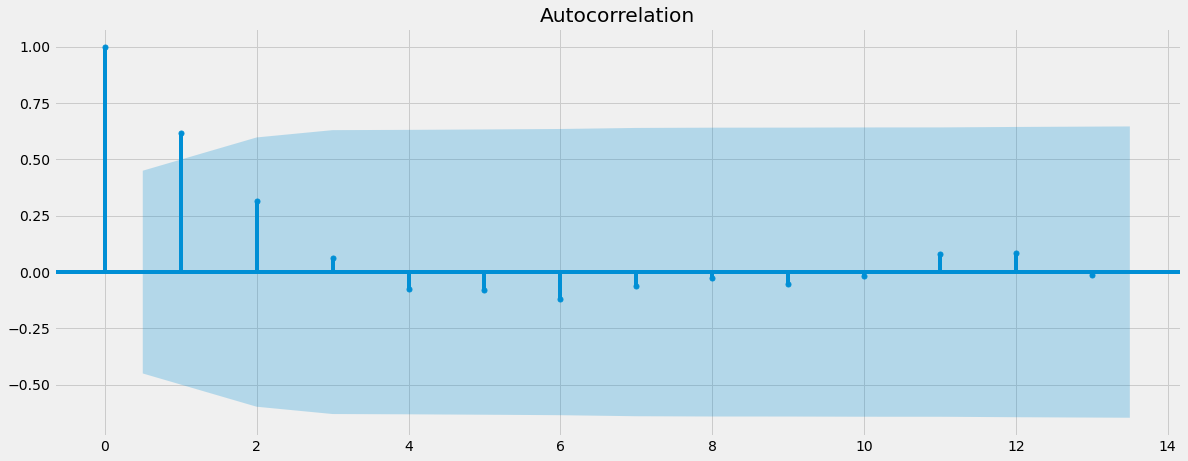

In [182]:
# Check out a plot of autocorrelations

# Here, you import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_2)
plt.show()

Data does not have many lags that are significantly correlated with each other; there are only two autocorrelated data points.

# Stationarizing the Data

## 1st Round

In [183]:
data_diff = data_2 - data_2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [184]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [185]:
data_diff.head()

,Value
datetime,
2003-01-01,511.0
2004-01-01,60.0
2005-01-01,416.0
2006-01-01,311.0
2007-01-01,-180.0


In [186]:
data_diff.columns

Index(['Value'], dtype='object')

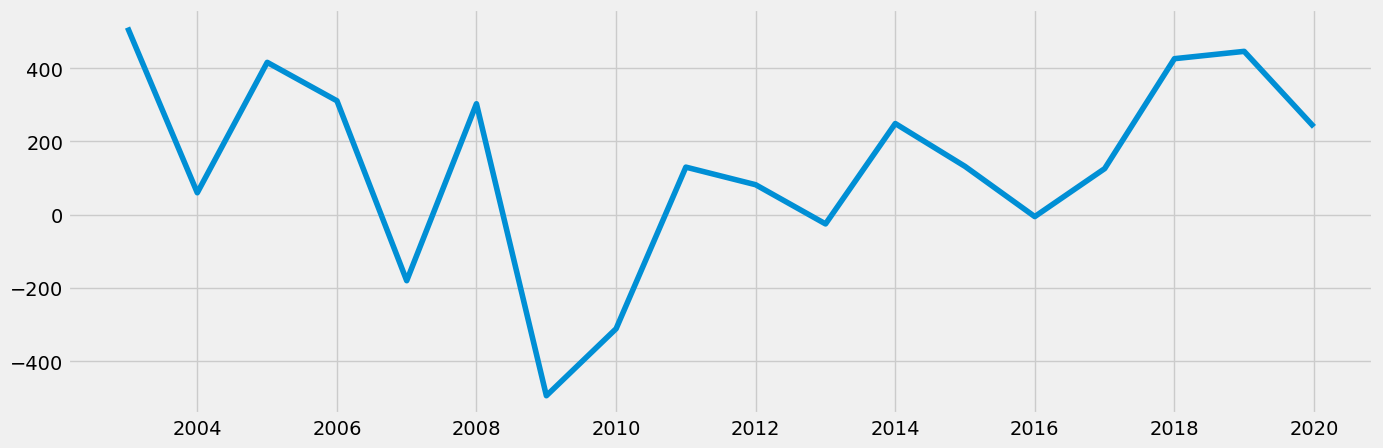

In [187]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [188]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.393696
p-value                         0.585294
Number of Lags Used             2.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


The test statistic remains higher than the critical level (5%) after the first round of differencing. The data is still non-stationary, thus, we cannot reject the null hypothesis.

## 2nd Round

In [189]:
data_diff_2 = data_diff - data_diff.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [190]:
data_diff_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [191]:
data_diff_2.head()

,Value
datetime,
2004-01-01,-451.0
2005-01-01,356.0
2006-01-01,-105.0
2007-01-01,-491.0
2008-01-01,483.0


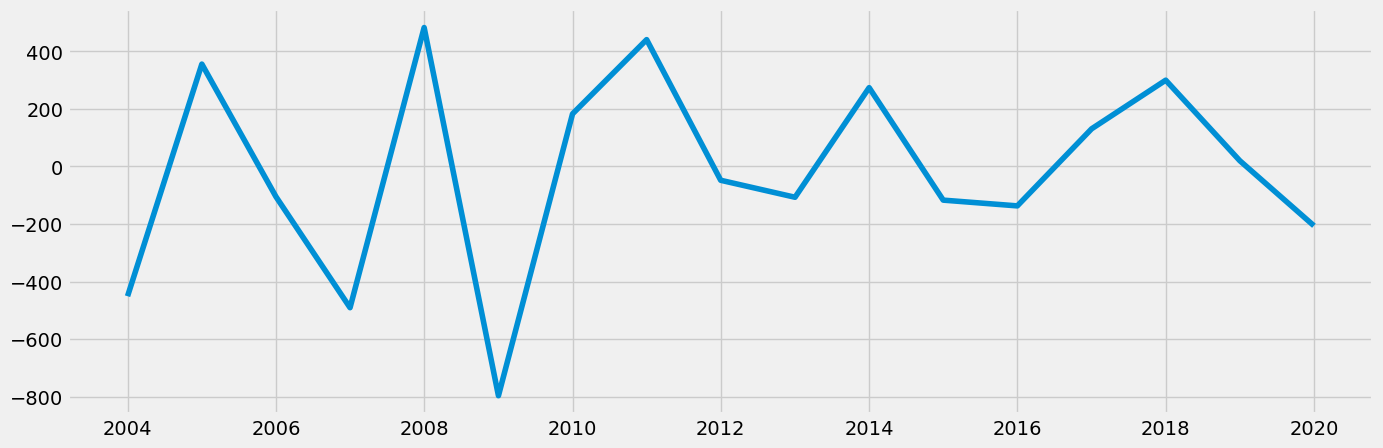

In [192]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [193]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.726630
p-value                         0.000075
Number of Lags Used             1.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


After the second round of differencing, the test statistic is lower than the critical value (5%), indicating that the data is stationary. We can now reject the null hypothesis and proceed with the forecast.